In [1]:
# Sample to be processed
study = 'scmznos_valtor_combined'


In [2]:
# Input/output/resource directories
place = 'nemo'
scratchdir = "/plus/scratch/users/scott/projects/scmznos_valtor"
rawdir = f'{scratchdir}/raw_data'
outdir = f'{scratchdir}/project_results'
datadir = f'{scratchdir}/resources'
commonsdir = '/plus/data/@data_scott/common_resources'
syncdir='/home/scott/Sync/scmznos_sync'


In [3]:
# Load libraries
import os
import sklearn
import pickle
import pandas as pd
import numpy as np
import scipy
from scipy.sparse import csr_matrix
from scipy import io

import scanpy as sc
import anndata as ad
import pybiomart as pbm
import leidenalg as la
import scrublet as scr

import graphtools as gt
from pygsp import graphs, filters
import phate
import magic
import scprep
import sklearn
import meld

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import time
import natsort

# Package settings
sc.settings.autosave = False
sc.settings.figdir = f'{syncdir}/'
np.random.seed(42)
font = {'size'   : 14}
mpl.rc('font', **font)
mpl.rcParams['animation.embed_limit'] = 1000
mpl.rcParams['pdf.fonttype'] = 42

In [4]:
# Show loaded libraries
import session_info
session_info.show()

### Compare KO 3 and neural-early marker genes

In [5]:
# Load preprocessed data
sdata = sc.read_h5ad(f'{scratchdir}/preprocessed_data/Anndata_scmznos_valtor_combined_cells_preprocessed_annotated_FINAL.h5ad')
sdata

AnnData object with n_obs × n_vars = 10551 × 19782
    obs: 'Sample', 'Mutant_A', 'Mutant_B', 'WT_A', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_noncoding', 'log1p_total_counts_noncoding', 'pct_counts_noncoding', 'total_counts_label', 'log1p_total_counts_label', 'pct_counts_label', 'Raw_GFPCAAX', 'Raw_DSRED38WT', 'Raw_HCD4ENRICHED', 'Detected_GFPCAAX', 'Detected_DSRED38WT', 'Detected_HCD4ENRICHED', 'Detected_number', 'Detected_any', 'Transplant', 'Transplant_WT', 'Transplant_KO', 'Condition_marker', 'WT_marker', 'KO_marker', 'Host_marker', 'log10_total_counts', 'Condition_SNP', 'Condition', 'Expression_GFPCAAX', 'Expression_DSRED38WT', 'E

In [6]:
# Add NPS bound annotation from Liyun
NPS_open_5kb = pd.read_csv(f"{commonsdir}/gene_lists/N_P_S_cobound_open_5kb_genes.txt", delimiter='\t', header=None, names=['Chromosome', 'Start', 'End', 'gene'], index_col=False)
sdata.var['NPS_open_5kb'] = sdata.var.EnsemblID.isin(NPS_open_5kb['gene'].to_list())


/tmp/ipykernel_855377/1626902061.py:2: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  NPS_open_5kb = pd.read_csv(f"{commonsdir}/gene_lists/N_P_S_cobound_open_5kb_genes.txt", delimiter='\t', header=None, names=['Chromosome', 'Start', 'End', 'gene'], index_col=False)


In [7]:
# Annotate genes with mir430 binding information
GTF = pd.read_csv(f'{datadir}/GRCz11_104_3_prime_UTR.csv')
sdata.var['mir430_seed'] = sdata.var.EnsemblID.isin(GTF[GTF.mir430_motif_seed].gene_id)


/tmp/ipykernel_855377/1650237759.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  GTF = pd.read_csv(f'{datadir}/GRCz11_104_3_prime_UTR.csv')


In [8]:
# Load and annotate Amaral annotations
MZT_Amaral = pd.read_csv(f'{commonsdir}/gene_lists/20240912_MZT_gene_annotation_Amaral_2024.csv', index_col=0)[['mzt_gene_class', 'target']]
sdata.var['strictly_maternal_Amaral'] = sdata.var.gene_ids.isin(MZT_Amaral[MZT_Amaral.mzt_gene_class.isin(['maternal'])].index.to_list())
sdata.var['maternal_zygotic_Amaral'] = sdata.var.gene_ids.isin(MZT_Amaral[MZT_Amaral.mzt_gene_class.isin(['maternal_zygotic'])].index.to_list())
sdata.var['strictly_zygotic_Amaral'] = sdata.var.gene_ids.isin(MZT_Amaral[MZT_Amaral.mzt_gene_class.isin(['zygotic'])].index.to_list())
sdata.var['total_maternal_Amaral'] = sdata.var.gene_ids.isin(MZT_Amaral[MZT_Amaral.mzt_gene_class.isin(['maternal', 'maternal_zygotic'])].index.to_list())
sdata.var['activated_late_Amaral'] = ~(sdata.var['total_maternal_Amaral'] | sdata.var['strictly_zygotic_Amaral'])
sdata.var['mir430_Amaral'] = sdata.var.gene_ids.isin(MZT_Amaral[MZT_Amaral.target.str.contains('target')].index.to_list())
sdata.var['total_mir430_Amaral'] = sdata.var['mir430_Amaral'] | sdata.var['mir430_seed']

MZT_lists = ['NPS_open_5kb',
             'strictly_maternal_Amaral',
             'maternal_zygotic_Amaral',
             'strictly_zygotic_Amaral',
             'total_mir430_Amaral']

In [9]:
clust1 = 'KO 3' # <- first cluster of interest (will have positive LFC in the results)
clust2 = 'Neural-early' # <- second cluster of interest (will have negative LFC in the results)


/tmp/ipykernel_855377/505621790.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sdata.obs['Key_clusts'][~sdata.obs['Key_clusts'].isin([clust1, clust2])] = np.nan
/tmp/ipykernel_855377/505621790.py:6: SettingWithCopyWarning: 
A value is t

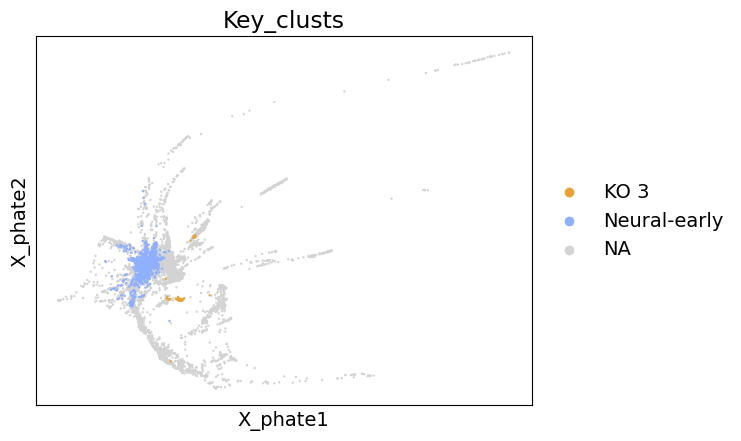

In [10]:
# Generate an embedding highlighting the 2 populations of interest
Tissue_KO_clusters_cats = sdata.obs.Tissue_KO_clusters.cat.categories.to_list()
Tissue_KO_clusters_colors = ['#A5DEF0', '#A8CF47', '#E9A238', '#8061AA', '#E82D5B', '#006fa6', '#a30059', '#ffdbe5', '#7a4900', '#0000a6', '#63ffac', '#b79762', '#004d43', '#8fb0ff', '#997d87', '#5a0007', '#809693', '#6a3a4c', '#1b4400', '#4fc601', '#3b5dff', '#4a3b53', '#ff2f80', '#61615a', '#ba0900', '#6b7900', '#00c2a0', '#ffaa92', '#ff90c9', '#b903aa', '#d16100', '#82d4f7', '#000035']

sdata.obs['Key_clusts'] = sdata.obs['Tissue_KO_clusters'].astype(str)
sdata.obs['Key_clusts'][~sdata.obs['Key_clusts'].isin([clust1, clust2])] = np.nan
sdata.obs['Key_clusts'] = sdata.obs['Key_clusts'].astype('category')
sdata.obs['Key_clusts'] = sdata.obs['Key_clusts'].cat.reorder_categories([clust1, clust2])
sdata.uns['Key_clusts_colors'] = [i for i, j in zip(Tissue_KO_clusters_colors, Tissue_KO_clusters_cats) if j in [clust1, clust2]]
# sdata.uns['Tissue_KO_clusters_colors'] = ['#A5DEF0', '#A8CF47', '#E9A238', '#8061AA', '#E82D5B', '#006fa6', '#a30059', '#ffdbe5', '#7a4900', '#0000a6', '#63ffac', '#b79762', '#004d43', '#8fb0ff', '#997d87', '#5a0007', '#809693', '#6a3a4c', '#1b4400', '#4fc601', '#3b5dff', '#4a3b53', '#ff2f80', '#61615a', '#ba0900', '#6b7900', '#00c2a0', '#ffaa92', '#ff90c9', '#b903aa', '#d16100', '#82d4f7', '#000035']
sc.pl.embedding(sdata, basis='X_phate', color='Key_clusts', save=f'scMZnps_{clust2}_{clust1}_embedding.pdf')


In [11]:
# Load PGC markers
common_markers = pd.read_csv(f'{syncdir}/Tissue_KO_clusters/Tissue_Marker_Enrichment_Tissue_KO_clusters_{clust1}.csv', index_col=0)
common_markers = str(common_markers[common_markers.Term == clust2].reset_index().at[0, 'Genes']).split(";")
common_markers

['emx3',
 'ek1',
 'dmrta2',
 'mex3b',
 'wnt8b',
 'sp8b',
 'efnb2b',
 'rfx4',
 'letm1',
 'sox2',
 'sox19a',
 'si:ch211-212k18.5',
 'plxdc2',
 'olig3',
 'nsd2',
 'pou3f2b',
 'lfng',
 'pcdh18a',
 'spsb4a',
 'auts2b',
 'zic2b',
 'fezf2',
 'pax3a']

In [12]:
# Create bubble plot of markers
GOIs = {}
WT_marker_annotation = [pd.read_csv(f'{outdir}/Tissue_KO_clusters/DEGs_Tissue_KO_clusters_cluster_{clust}.csv', index_col=0).sort_values('combined_rank') for clust in list(sdata[sdata.obs.Condition != 'KO'].obs['Tissue_KO_clusters'].unique())]
WT_marker_annotation = pd.concat(WT_marker_annotation)
WT_marker_annotation = WT_marker_annotation.merge(sdata.var, how='left', left_index=True, right_index=True)

WT_marker_annotation = WT_marker_annotation[(WT_marker_annotation.either_sig) & (WT_marker_annotation.pct_nz_reference < 0.5) & (WT_marker_annotation.Biotype == 'protein_coding') & (WT_marker_annotation.logOR > 0)]

# View top TFs for a specific cluster
n_genes = 50 # Number of genes per tissue
marker_annotation = WT_marker_annotation.sort_values(['Cluster', 'combined_rank']).groupby('Cluster').head(n_genes)
tissue_markers = {k: g["names"].tolist() for k,g in marker_annotation.groupby("Cluster")}
total_markers = tissue_markers[clust2]
total_markers

['sox19a',
 'sox3',
 'zic2b',
 'zic2a',
 'pax3a',
 'mecom',
 'her8a',
 'mex3b',
 'emx3',
 'mapk12b',
 'lfng',
 'dmrta2',
 'sox19b',
 'tdgf1',
 'sox2',
 'chrd',
 'wnt8b',
 'pcdh18a',
 'sptbn5',
 'si:ch211-212k18.5',
 'fezf2',
 'auts2b',
 'hnf1ba',
 'cdh6',
 'zgc:64002',
 'wnt1',
 'foxg1a',
 'fgf8a',
 'zic3',
 'fgf17',
 'zgc:114118',
 'hesx1',
 'zic4',
 'nsd2',
 'letm1',
 'sema3fa',
 'msi1',
 'olig3',
 'en2a',
 'spsb4a',
 'ek1',
 'rfx4',
 'sp8b',
 'pkdcca',
 'plxdc2',
 'inhbaa',
 'dchs1b',
 'pou3f2b',
 'fgf3',
 'efnb2b']

In [13]:
# Markers common and missing between populations
diff_markers = {}
diff_markers['common'] = common_markers
diff_markers['missing'] = [i for i in total_markers if i not in common_markers]
diff_markers

{'common': ['emx3',
  'ek1',
  'dmrta2',
  'mex3b',
  'wnt8b',
  'sp8b',
  'efnb2b',
  'rfx4',
  'letm1',
  'sox2',
  'sox19a',
  'si:ch211-212k18.5',
  'plxdc2',
  'olig3',
  'nsd2',
  'pou3f2b',
  'lfng',
  'pcdh18a',
  'spsb4a',
  'auts2b',
  'zic2b',
  'fezf2',
  'pax3a'],
 'missing': ['sox3',
  'zic2a',
  'mecom',
  'her8a',
  'mapk12b',
  'sox19b',
  'tdgf1',
  'chrd',
  'sptbn5',
  'hnf1ba',
  'cdh6',
  'zgc:64002',
  'wnt1',
  'foxg1a',
  'fgf8a',
  'zic3',
  'fgf17',
  'zgc:114118',
  'hesx1',
  'zic4',
  'sema3fa',
  'msi1',
  'en2a',
  'pkdcca',
  'inhbaa',
  'dchs1b',
  'fgf3']}

In [14]:
# View top genes for each cluster
from sklearn.preprocessing import MinMaxScaler

for i in list(diff_markers.keys()):
    X = sdata.to_df()[diff_markers[i]].groupby(sdata.obs.Tissue_KO_clusters).mean()
    scaler = MinMaxScaler()
    X[X.columns.to_list()] = scaler.fit_transform(X)    
    X = X.T
    names = X.index
    Z = scipy.cluster.hierarchy.linkage(X.values, 'complete')
    dn = scipy.cluster.hierarchy.dendrogram(Z, labels=names.tolist(), orientation='right', no_plot=True)
    
    diff_markers[i] = dn['ivl']


/tmp/ipykernel_855377/1447901279.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X = sdata.to_df()[diff_markers[i]].groupby(sdata.obs.Tissue_KO_clusters).mean()
/tmp/ipykernel_855377/1447901279.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X = sdata.to_df()[diff_markers[i]].groupby(sdata.obs.Tissue_KO_clusters).mean()


/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via '

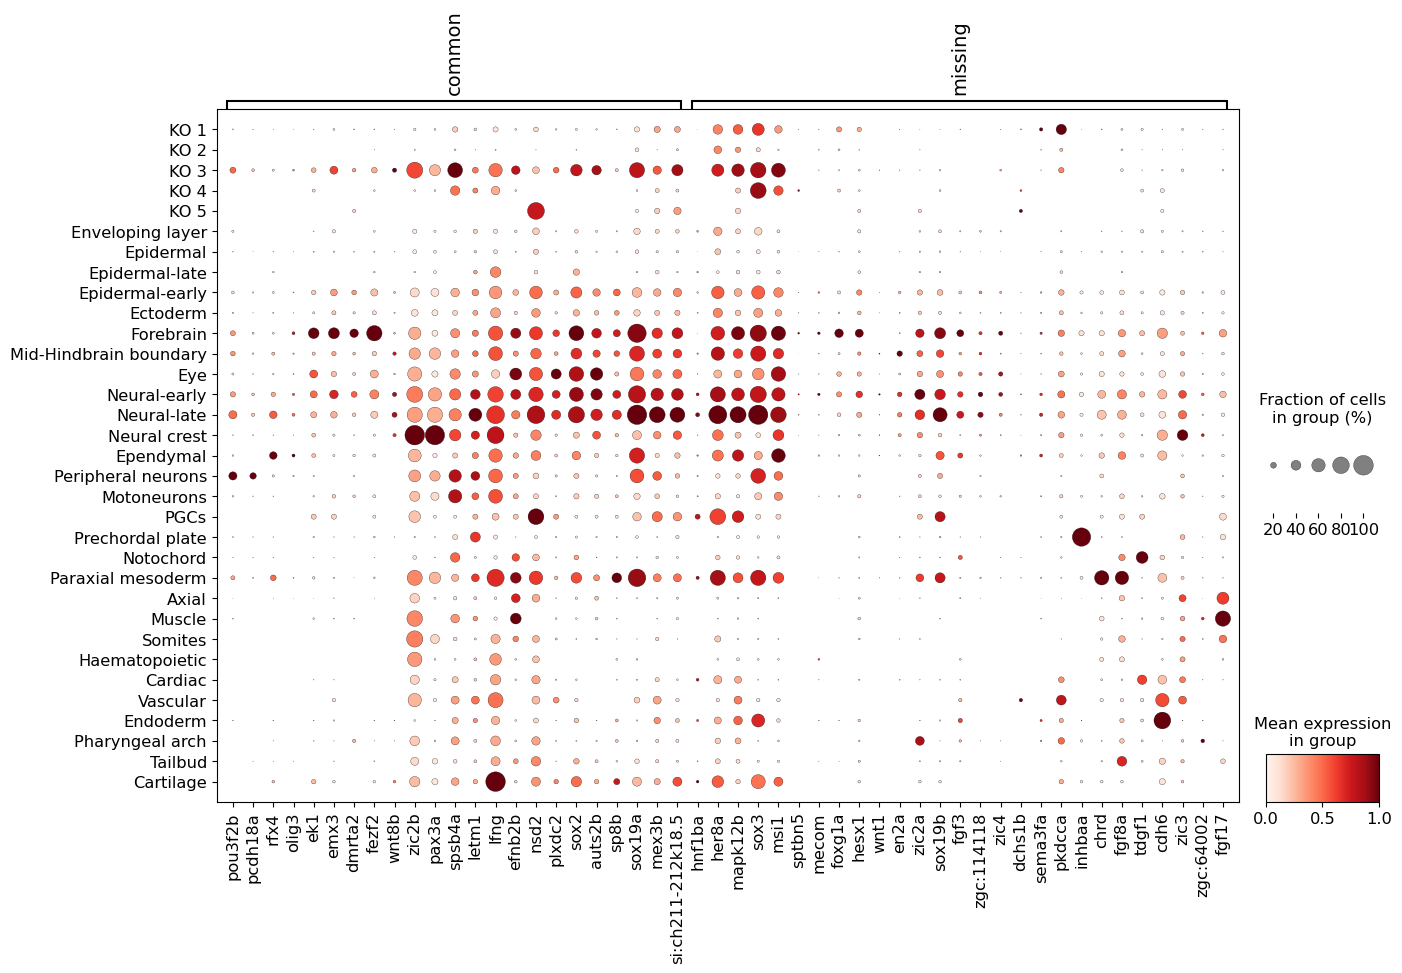

In [15]:
reor = ["KO 1", "KO 2", "KO 3", "KO 4", "KO 5", "Enveloping layer", "Epidermal", "Epidermal-late", "Epidermal-early", "Ectoderm", "Forebrain", "Mid-Hindbrain boundary", "Eye", "Neural-early", "Neural-late", "Neural crest", "Ependymal", "Peripheral neurons", "Motoneurons", "PGCs", "Prechordal plate", "Notochord", "Paraxial mesoderm", "Axial", "Muscle", "Somites", "Haematopoietic", "Cardiac", "Vascular", "Endoderm", "Pharyngeal arch", "Tailbud", "Cartilage"]
# reor = ["KO 1", "KO 2", "KO 3", "KO 4", "KO 5", "Epidermal", "Epidermal-early", "Ectoderm", "Prechordal plate", "Cardiac", "Endoderm", "Mid-Hindbrain boundary", "Neural-early", "Forebrain", "Neural-late", "Neural crest", "Eye", "Peripheral neurons", "Motoneurons", "Muscle", "Pharyngeal arch", "PGCs", "Axial", "Enveloping layer", "Epidermal-late", "Haematopoietic", "Notochord", "Paraxial mesoderm", "Somites", "Tailbud", "Vascular", "Cartilage", "Ependymal"]
sdata.obs['Tissue_KO_clusters'] = sdata.obs['Tissue_KO_clusters'].cat.reorder_categories(reor)

sc.pl.dotplot(sdata, diff_markers, 'Tissue_KO_clusters', standard_scale='var', figsize=(15,9), save=f'scMZnps_{clust2}_{clust1}_markerDE.pdf')


In [16]:
sdata.var['common_markers'] = sdata.var.index.isin(common_markers)

### Direct comparison between populations

In [17]:
from statsmodels.stats.multitest import multipletests  # Corrects for multiple hypothesis testing
from fisher import pvalue_npy  # Computes Fisher's exact test in vectorized form
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis

def OR(adata, cluster_col='Subtissue', cluster='Integument', eps=1e-7, correction='fdr_bh', 
       return_significant=True, p_threshold=0.05, OR_cutoff=None, FE_cutoff=None):
    """
    Calculates Odds Ratio (OR), Fold Enrichment (FE), and significance for gene expression in a cluster.
    
    Parameters:
    - adata: AnnData object containing expression data (sparse matrix format)
    - cluster_col: Column in `adata.obs` denoting cluster assignments
    - cluster: Cluster of interest
    - eps: Small constant to avoid division by zero
    - correction: Multiple hypothesis testing correction method
    - return_significant: If True, filters results by significance
    - p_threshold: Threshold for adjusted p-values
    - OR_cutoff: Minimum OR for filtering results
    - FE_cutoff: Minimum Fold Enrichment for filtering results
    
    Returns:
    - DataFrame with calculated statistics for each gene
    """
    
    # Binarize expression data (convert non-zero to 1)
    detection_data = adata.X.copy()
    detection_data.data[detection_data.data != 0] = 1

    # Binarize cluster membership and make 1D array
    membership = np.array(adata.obs[cluster_col] == cluster)  # Boolean array for cluster membership
    membership_data = np.reshape(membership, (detection_data.shape[0], 1)).astype(int)  # Reshape to match dimensions

    # Calculate contingency table
    tp = np.sum(np.add(membership_data, detection_data.toarray()) == 2, axis=0).astype(np.uint)  # True positives
    fp = np.sum(np.subtract(detection_data.toarray(), membership_data) == 1, axis=0).astype(np.uint)  # False positives
    fn = np.sum(np.subtract(membership_data, detection_data.toarray()) == 1, axis=0).astype(np.uint)  # False negatives
    tn = np.sum(np.add(membership_data, detection_data.toarray()) == 0, axis=0).astype(np.uint)  # True negatives

    # Calculate Odds Ratio (OR)
    OR = ((tp + eps) / (fp + eps)) / ((fn + eps) / (tn + eps))  # Avoid division by zero using `eps`
    # OR = np.nan_to_num(OR)  # Handle NaN values explicitly if uncommented

    # Calculate Fold Enrichment (FE)
    FE = ((tp + eps) / (tp + fn + eps)) / ((tp + fp + eps) / (tp + fp + fn + tn + eps))
    
    # Fisher's exact test
    _, _, twosided = pvalue_npy(tp, fp, fn, tn)  # Two-sided p-value

    # Correct for multiple hypothesis testing
    _, p_adjusted, _, _ = multipletests(twosided, alpha=0.05, method=correction)

    # Compile results into a DataFrame
    df = pd.DataFrame({
        "Cluster": cluster,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn,
        "FE": FE,
        "OR": OR,
        "logOR": np.log2(OR),
        "P": twosided,
        "P_adjust": p_adjusted,
        "log10P_adjust": -np.log10(p_adjusted)
    }, index=adata.var_names)

    # Filter results by significance, OR, and FE thresholds
    if return_significant:
        df = df[df['P_adjust'] <= p_threshold]
    if OR_cutoff is not None:
        df = df[df['OR'] >= OR_cutoff]
    if FE_cutoff is not None:
        df = df[df['FE'] >= FE_cutoff]

    # Clean up memory
    del detection_data
    del membership_data

    # Return sorted DataFrame by logOR
    return df.sort_values(by=['logOR'], ascending=[False])


In [18]:
from joblib import Parallel, delayed  # Parallel processing utilities
import scanpy as sc  # Single-cell analysis library
import pandas as pd

def enrichment(adata, clusters, n_jobs=3):
    """
    Perform enrichment analysis by combining Odds Ratio and t-test results for single-cell data.
    
    Parameters:
    - adata: AnnData object with single-cell data
    - clusters: Column in `adata.obs` denoting clusters (must be categorical)
    - n_jobs: Number of parallel jobs to run
    
    Returns:
    - Dictionary containing enriched genes for each cluster with combined rankings and significance
    """
    # Validate that the cluster column is categorical
    if not pd.api.types.is_categorical_dtype(adata.obs[clusters]):
        raise ValueError(f"The column '{clusters}' must be categorical.")

    # Define a function to compute OR for a single cluster
    def compute_or(cluster):
        return OR(adata, cluster_col=clusters, cluster=cluster, eps=1e-7, correction='fdr_bh', return_significant=False)

    # Compute Odds Ratios in parallel for all clusters
    OR_results = Parallel(n_jobs=n_jobs, prefer="threads")(
        delayed(compute_or)(cluster) for cluster in adata.obs[clusters].cat.categories
    )
    
    # Convert OR results to a dictionary indexed by cluster
    OR_dict = {result['Cluster'].iloc[0]: result for result in OR_results}

    # Perform t-test for differential expression
    sc.tl.rank_genes_groups(
        adata, groupby=clusters, use_raw=False, method='t-test_overestim_var', n_genes=None, pts=True
    )

    # Combine Odds Ratio and t-test results
    DG_dict = {}
    for cluster in OR_dict.keys():
        # Extract Odds Ratio results and rank by OR
        OR_df = OR_dict[cluster].copy()
        OR_df['OR_rank'] = range(1, OR_df.shape[0] + 1)

        # Extract t-test results and rank by scores
        DEGs = sc.get.rank_genes_groups_df(adata, group=cluster).sort_values(by='scores', ascending=False)
        DEGs['lfc_rank'] = range(1, DEGs.shape[0] + 1)
        DEGs.set_index('names', inplace=True)  # Ensure gene names are used as the index

        # Merge results on gene names and calculate combined metrics
        DGs = pd.concat([OR_df, DEGs], axis=1, join='inner')
        DGs['combined_rank'] = DGs['OR_rank'] + DGs['lfc_rank']
        DGs['both_sig'] = (DGs['P_adjust'] < 0.05) & (DGs['pvals_adj'] < 0.05)
        DGs['either_sig'] = (DGs['P_adjust'] < 0.05) | (DGs['pvals_adj'] < 0.05)

        # Add to results dictionary
        DG_dict[cluster] = DGs

    return DG_dict


In [19]:
res = 'Tissue_KO_clusters' # <- Change cluster resolution to partition data
# clust1 = 'KO 4' # <- first cluster of interest (will have positive LFC in the results)
# clust2 = 'Peripheral neurons' # <- second cluster of interest (will have negative LFC in the results)
genes = list(np.ravel((sdata[sdata.obs[res].isin([clust1, clust2])].X != 0).sum(axis=0) > 0))

comparison2way = enrichment(sdata[sdata.obs[res].isin([clust1, clust2]), genes], res)

# for clust in list(comparison2way.keys()):
#     comparison2way[clust].sort_values('combined_rank').to_csv(f'{outdir}/clusters/DEGs_{clust1}_vs_{clust2}_{clust}up.csv')


/tmp/ipykernel_855377/2299921389.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(adata.obs[clusters]):
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/get/

In [20]:
top_genes_all = comparison2way[clust1].sort_values('combined_rank', ascending=True)
top_genes_all = top_genes_all.merge(sdata.var, how='left', left_index=True, right_index=True)
# top_genes_all.to_csv(f'{syncdir}/DEGs_{clust2}_vs_{clust1}.csv')

### Test enrichment of MZT sets

In [21]:
# Calculate hypergeometric p-value for genesets in DEGs (down regulated in KO 5

# Set significance threshold
pval = 0.01

import gseapy as gp
res_dfs = []

# Create MZT dictionary
gs_dict = {}

for gs in MZT_lists:
    # Create dataframe of apoptosis genes
    gs_dict[gs] = sdata.var[sdata.var[gs]].index.to_list()

# Create lists of DEGs
DEGs = {}
DEGs['KO_up'] = top_genes_all[(top_genes_all.P_adjust < pval) & (top_genes_all.pvals_adj < pval) & (top_genes_all.Biotype == 'protein_coding') & (top_genes_all.logfoldchanges > 2)].index.to_list()
DEGs['KO_down'] = top_genes_all[(top_genes_all.P_adjust < pval) & (top_genes_all.pvals_adj < pval) & (top_genes_all.Biotype == 'protein_coding') & (top_genes_all.logfoldchanges < -2)].index.to_list()

# Test enrichment for each list
for clust in ['KO_up', 'KO_down']:
    # top_genes = pd.read_csv(f'{outdir}/clusters/DEGs_{res}_cluster_{clust}.csv', index_col=0)
    # top_genes = top_genes[top_genes.names.isin((list(sdata.var.GeneSymbol[((sdata.var.n_cells_by_counts/sdata.shape[0]) < 0.5) & sdata.var.AnySpecies_TFs])))]
    
    # gene_list = top_genes[(top_genes.P_adjust < 0.05) | (top_genes.pvals_adj < 0.05)].sort_values('combined_rank').head(500)
    gene_list = DEGs[clust]
    print(f'Number of genes in {clust}: {len(gene_list)}')

    # Get significantly enriched terms
    enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                     gene_sets=gs_dict, # kegg is a dict object
                     background=sdata.var.index.to_list(), # or "hsapiens_gene_ensembl", or int, or text file, or a list of genes
                     cutoff=0.05,
                     outdir=None,
                     verbose=True)
    
    results = enr2.results
    results = results.sort_values('Adjusted P-value', ascending=True)
    results['logOR'] = np.log2(results['Odds Ratio'])
    results['log10_p'] = -np.log10(results['Adjusted P-value'])
    results['sig'] = results['Adjusted P-value'] < 0.05
    results['Cluster'] = clust
    results.to_csv(f'{syncdir}/DEG_{clust1}_{clust2}_{clust}_MZT_enrichment.csv')
    results.to_csv(f'{outdir}/DEG_{clust1}_{clust2}_{clust}_MZT_enrichment.csv')
    print(results)
    res_dfs.append(results)


2025-06-05 12:24:13,852 [INFO] Input dict object named with gs_ind_0
2025-06-05 12:24:13,853 [INFO] Run: gs_ind_0 
2025-06-05 12:24:13,861 [INFO] Done.
2025-06-05 12:24:13,877 [INFO] Input dict object named with gs_ind_0
2025-06-05 12:24:13,877 [INFO] Run: gs_ind_0 
2025-06-05 12:24:13,887 [INFO] Done.


Number of genes in KO_up: 62
   Gene_set                      Term  Overlap   P-value  Adjusted P-value  \
3  gs_ind_0   strictly_zygotic_Amaral    9/811  0.000904          0.004518   
4  gs_ind_0       total_mir430_Amaral  24/5718  0.061504          0.153760   
0  gs_ind_0              NPS_open_5kb  10/4215  0.878057          0.952634   
1  gs_ind_0   maternal_zygotic_Amaral  10/4767  0.952634          0.952634   
2  gs_ind_0  strictly_maternal_Amaral   7/3376  0.922741          0.952634   

   Odds Ratio  Combined Score  \
3    4.151289       29.096476   
4    1.565120        4.364579   
0    0.738584        0.096048   
1    0.629911        0.030566   
2    0.656625        0.052797   

                                               Genes     logOR   log10_p  \
3  h1f0;cxcl12b;slc13a4;serpinh1b;lgals3b;ifi45;h...  2.053559  2.345010   
4  sparc;cxcl12b;nr2f2;si:ch211-286o17.1;si:ch73-...  0.646273  0.813157   
0  pik3r3b;map1lc3b;lmx1bb;mdka;si:ch211-286o17.1... -0.437166  0.021074   

/tmp/ipykernel_855377/1439951199.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  res_df['log10_p'][~res_df['sig']] = 0
/tmp/ipykernel_855377/1439951199.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

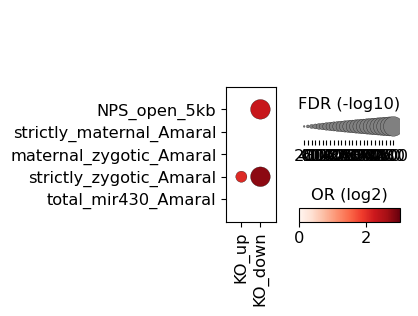

In [22]:
# Create bubble plot of enrihcment results
res_comb = pd.concat(res_dfs)
res_comb['Cluster'] = res_comb['Cluster'].astype('category')
res_comb['Cluster'] = res_comb['Cluster'].cat.reorder_categories(['KO_up', 'KO_down'])
res_comb['Term'] = res_comb['Term'].astype('category')
res_comb['Term'] = res_comb['Term'].cat.reorder_categories(MZT_lists)

res_df = res_comb.copy()
# res_df = res_df[res_df['sig']]
res_df['log10_p'][~res_df['sig']] = 0
res_df['Term'] = res_df['Term'].astype('category')

marker = res_df.pivot_table(values='logOR', columns='Term', index='Cluster').fillna(0)
pval = res_df.pivot_table(values='log10_p', columns='Term', index='Cluster').fillna(0)
pval[pval > 5] = 5 # clip values to 8 logOR

dummy = sc.AnnData(marker)
dummy.var['Cluster'] = dummy.var_names.to_list()
dummy.obs['Term'] = dummy.obs_names.to_list()
dummy.obs['Term'] = dummy.obs['Term'].astype('category')

# Generate a dotplot for the enrichment results
sc.pl.dotplot(
    dummy, 
    var_names=dummy.var['Cluster'].to_list(),  # List of clusters
    groupby='Term',  # Terms are grouped on the y-axis
    dendrogram=False,  # Disable dendrogram as it may not be needed
    dot_color_df=marker,  # Colors represent log odds ratio (logOR)
    dot_size_df=pval,  # Sizes represent -log10(FDR)
    colorbar_title='OR (log2)',  # Title for the color scale
    size_title='FDR (-log10)',  # Title for the dot size scale
    vmin=0,  # Minimum value for dot color scale
    vmax=3,  # Maximum value for dot color scale
    cmap='Reds',  # Colormap for dot color
    swap_axes=True,  # Swap axes for better visualization
    # save=f'scMZnps_{clust2}_{clust1}_p01_DEGs_MZT_enrichment.pdf'  # Save the plot
)


### Look at expression of marker and DEGs in temporal bulk samples

In [23]:
# Load preprocessed data
sdata_bulk = sc.read_h5ad(f'/plus/scratch/users/scott/projects/mznps_timecourse/preprocessed_data/Anndata_mznps_timecourse_cells_preprocessed.h5ad')
sdata_bulk

AnnData object with n_obs × n_vars = 232 × 31901
    obs: 'Sample_id', 'Condition', 'Replicate', 'Timepoint', 'Sample_type', 'hpf', 'Batch', 'Library_size', 'Normalisation_factor'
    var: 'Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand', 'Frame', 'gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype'
    layers: 'X_normalised', 'X_preNorm'

In [24]:
# Subset to NP and WT from Batch B
sdata_bulk = sdata_bulk[(sdata_bulk.obs.Condition.isin(['MZnps', 'WT']) & (sdata_bulk.obs.Batch == 'B'))]
sdata_bulk

View of AnnData object with n_obs × n_vars = 70 × 31901
    obs: 'Sample_id', 'Condition', 'Replicate', 'Timepoint', 'Sample_type', 'hpf', 'Batch', 'Library_size', 'Normalisation_factor'
    var: 'Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand', 'Frame', 'gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype'
    layers: 'X_normalised', 'X_preNorm'

In [25]:
# Rename wnt 4 to wnt4a for compatability
# sdata_bulk.var[sdata_bulk.var.gene_id == sdata.var.loc['si:ch211-14a17.11'].gene_ids]
sdata_bulk.var.rename(index={'wnt4':'wnt4a'}, inplace=True)
sdata_bulk.var.rename(index={'CU855930.2':'CU855930.1'}, inplace=True)
sdata_bulk.var.rename(index={'GADD45G':'BX530077.1'}, inplace=True)
sdata_bulk.var.rename(index={'akr1b1.2':'si:dkey-180p18.9'}, inplace=True)
sdata_bulk.var.rename(index={'zgc:77118-1':'zgc:77118'}, inplace=True)
sdata_bulk.var.rename(index={'anxa1d':'ANXA1 (1 of many)'}, inplace=True)
sdata_bulk.var.rename(index={'ly6pge':'si:ch73-28h20.1'}, inplace=True)
sdata_bulk.var.rename(index={'lsp1a':'lsp1'}, inplace=True)
sdata_bulk.var.rename(index={'h1-0':'h1f0'}, inplace=True)
sdata_bulk.var.rename(index={'C2H14orf119':'si:ch211-14a17.11'}, inplace=True)
sdata_bulk.var.rename(index={"si:ch211-113a14.12":"zgc:110216"}, inplace=True)
sdata_bulk.var.rename(index={"eif1b":"zgc:56676"}, inplace=True)
sdata_bulk.var.rename(index={"hist1h4l-5":"zgc:165555-7"}, inplace=True)
sdata_bulk.var.rename(index={"hist1h4l-10":"zgc:165555-17"}, inplace=True)
sdata_bulk.var.rename(index={"FP236630.1":"hist1h2a4-3"}, inplace=True)
sdata_bulk.var.rename(index={"hist1h4l-21":"zgc:165555-12"}, inplace=True)
sdata_bulk.var.rename(index={"FQ312024.1":"HIST2H3A"}, inplace=True)
sdata_bulk.var.rename(index={"rasd2":"zgc:114118"}, inplace=True)


In [26]:
# # Find missing genes for use above
# for i in ['zgc:114118']:
#     j = sdata_bulk.var[sdata_bulk.var.gene_id == sdata.var.loc[i]['gene_ids']].index[0]
#     print(f'sdata_bulk.var.rename(index={{"{j}":"{i}"}}, inplace=True)')

In [27]:
# Scale expression values
sdata_bulk.raw = sdata_bulk.copy()
sc.pp.scale(sdata_bulk, copy = False)
sdata_bulk.X = scipy.sparse.csr_matrix(sdata_bulk.X)
sdata_bulk.layers["X_scaled"] = sdata_bulk.X
sdata_bulk.X = sdata_bulk.layers["X_normalised"]


In [28]:
from sklearn.preprocessing import MinMaxScaler

sdata_bulk.X = sdata_bulk.layers["X_scaled"]

# View top genes for each cluster
for i in list(DEGs.keys()):
    X = sdata_bulk.to_df()[DEGs[i][:50]].groupby(sdata_bulk.obs.Sample_type).mean()
    scaler = MinMaxScaler()
    X[X.columns.to_list()] = scaler.fit_transform(X)    
    X = X.T
    names = X.index
    Z = scipy.cluster.hierarchy.linkage(X.values, 'complete')
    dn = scipy.cluster.hierarchy.dendrogram(Z, labels=names.tolist(), orientation='right', no_plot=True)    
    DEGs[i] = dn['ivl']


/tmp/ipykernel_855377/2726081649.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X = sdata_bulk.to_df()[DEGs[i][:50]].groupby(sdata_bulk.obs.Sample_type).mean()
/tmp/ipykernel_855377/2726081649.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X = sdata_bulk.to_df()[DEGs[i][:50]].groupby(sdata_bulk.obs.Sample_type).mean()


/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


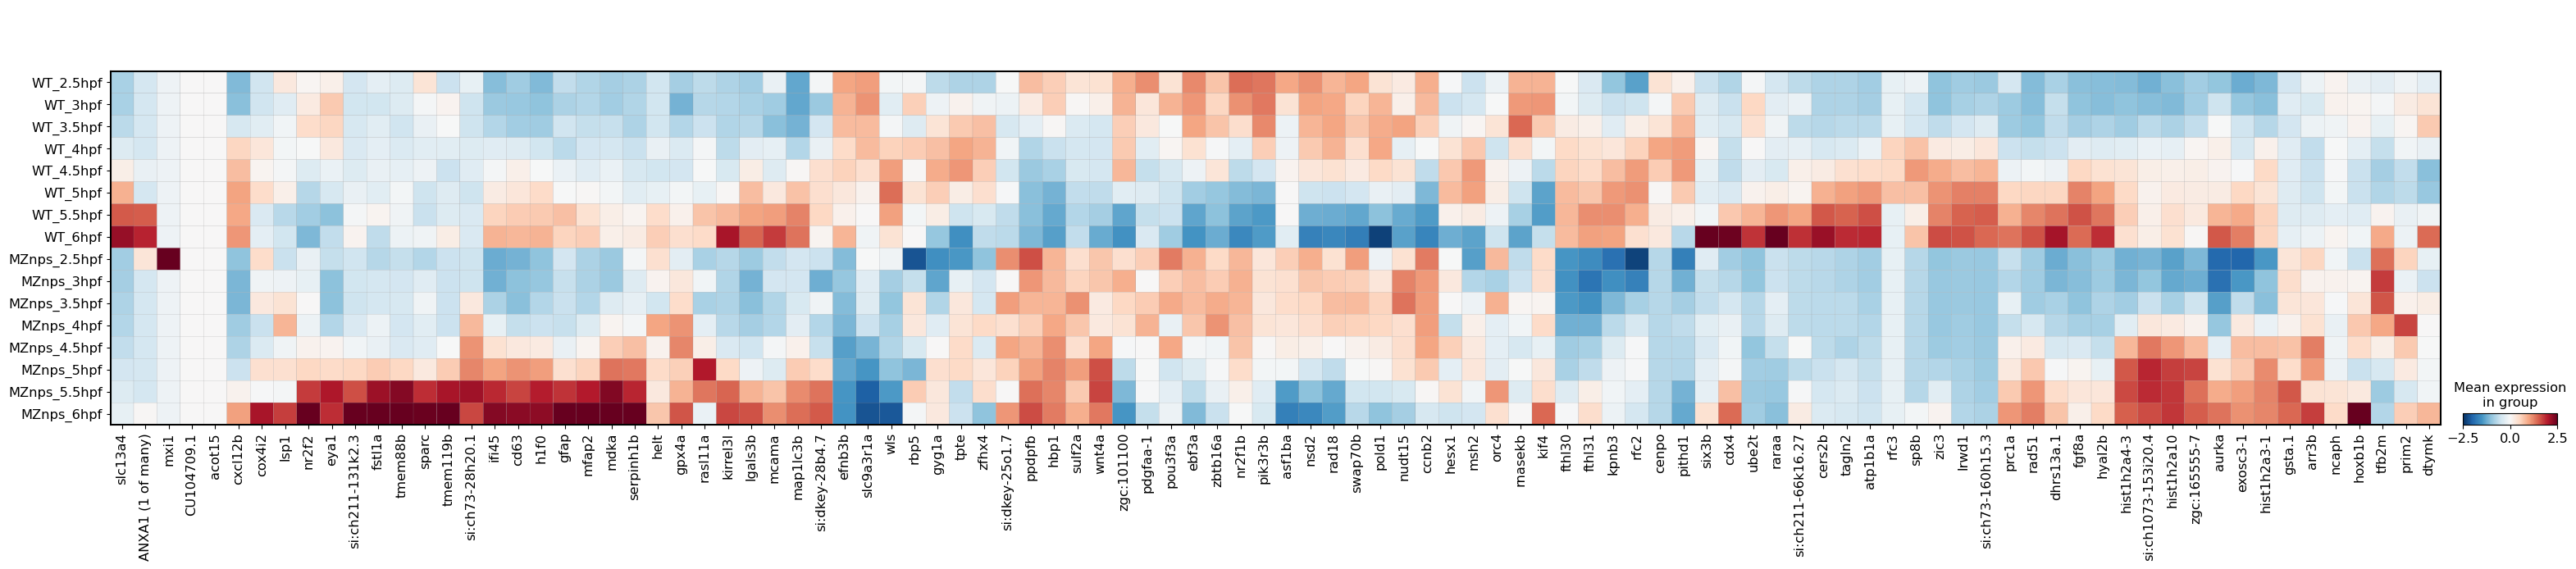

In [29]:
# Visualise marker expression temporally
sdata_bulk.obs['Sample_type'] = sdata_bulk.obs['Sample_type'].cat.reorder_categories(['WT_2.5hpf', 'WT_3hpf', 'WT_3.5hpf', 'WT_4hpf', 'WT_4.5hpf', 'WT_5hpf', 'WT_5.5hpf', 'WT_6hpf','MZnps_2.5hpf', 'MZnps_3hpf', 'MZnps_3.5hpf', 'MZnps_4hpf', 'MZnps_4.5hpf', 'MZnps_5hpf', 'MZnps_5.5hpf',  'MZnps_6hpf'])

# Generate a matrix plot for specified DEGs across 'Sample_type'
gene_list = [i for v in DEGs.values() for i in v]  # Flatten DEG dictionary

sc.pl.matrixplot(
    sdata_bulk, 
    gene_list,  # List of genes to plot
    groupby='Sample_type',  # Grouping by 'Sample_type'
    standard_scale=None,  # No scaling applied
    cmap='RdBu_r',  # Diverging colormap
    layer='X_scaled',  # Use scaled data
    vmin=-2.5,  # Minimum color value
    vmax=2.5,  # Maximum color value
    swap_axes=False,  # Do not swap axes
    # save=f'scMZnps_{clust2}_{clust1}_p01_bulk_timecourse.pdf'  # Save file
)


In [30]:
# Reverse the order of clusters
sdata.obs['Tissue_KO_clusters'] = sdata.obs['Tissue_KO_clusters'].cat.reorder_categories(sdata.obs['Tissue_KO_clusters'].cat.categories.to_list()[::-1])
sdata.uns['Tissue_KO_clusters_colors'] = ['#A5DEF0', '#A8CF47', '#E9A238', '#8061AA', '#E82D5B', '#006fa6', '#a30059', '#ffdbe5', '#7a4900', '#0000a6', '#63ffac', '#b79762', '#004d43', '#8fb0ff', '#997d87', '#5a0007', '#809693', '#6a3a4c', '#1b4400', '#4fc601', '#3b5dff', '#4a3b53', '#ff2f80', '#61615a', '#ba0900', '#6b7900', '#00c2a0', '#ffaa92', '#ff90c9', '#b903aa', '#d16100', '#82d4f7', '#000035'][::-1]


/tmp/ipykernel_855377/3979601073.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .obs.groupby('Tissue_KO_clusters')


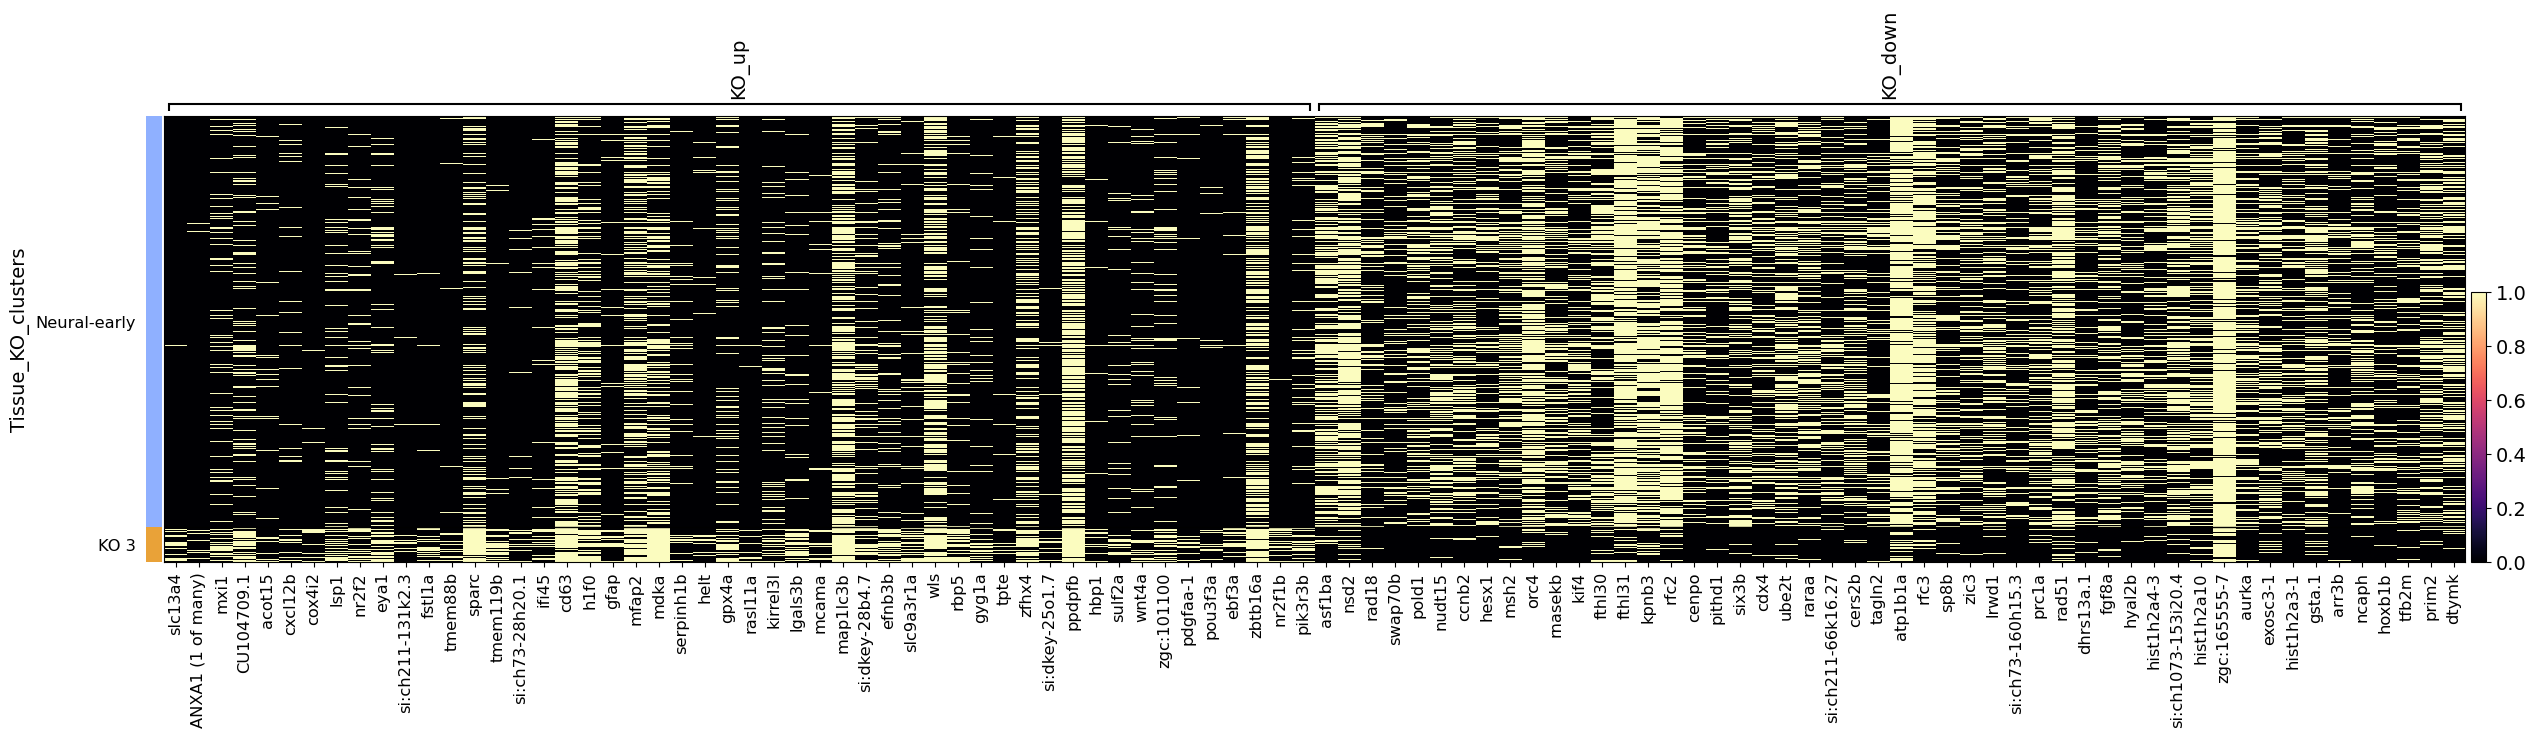

In [31]:
# Identify cells of interest (COIs)
COIs = (
    sdata[sdata.obs['Tissue_KO_clusters'].isin([clust1, clust2])]
    .obs.groupby('Tissue_KO_clusters')
    .head(200)
    .index.to_list()
    + sdata[sdata.obs['Tissue_KO_clusters'].isin([clust1, clust2])].obs.index.to_list()
)

# Generate the heatmap
sc.pl.heatmap(
    sdata[sdata.obs.index.isin(COIs)],  # Subset AnnData to cells of interest
    DEGs,  # Filtered list of DEGs
    groupby='Tissue_KO_clusters',  # Group by the specified cluster
    use_raw=False,  # Use processed data, not raw
    dendrogram=False,  # Disable dendrogram
    vmax=1,  # Maximum color value
    layer='X_preNorm',  # Use the specified layer
    cmap='magma',  # Colormap
    standard_scale=None,  # No scaling applied
    swap_axes=False,  # Do not swap axes
    show_gene_labels=True,  # Display gene labels
    # save=f'scMZnps_{clust2}_{clust1}_p01_detection.pdf'  # Save the plot
)


/tmp/ipykernel_855377/1466154293.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[i][df[i] == 1] = counter
/tmp/ipykernel_855377/1466154293.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setti

<Axes: >

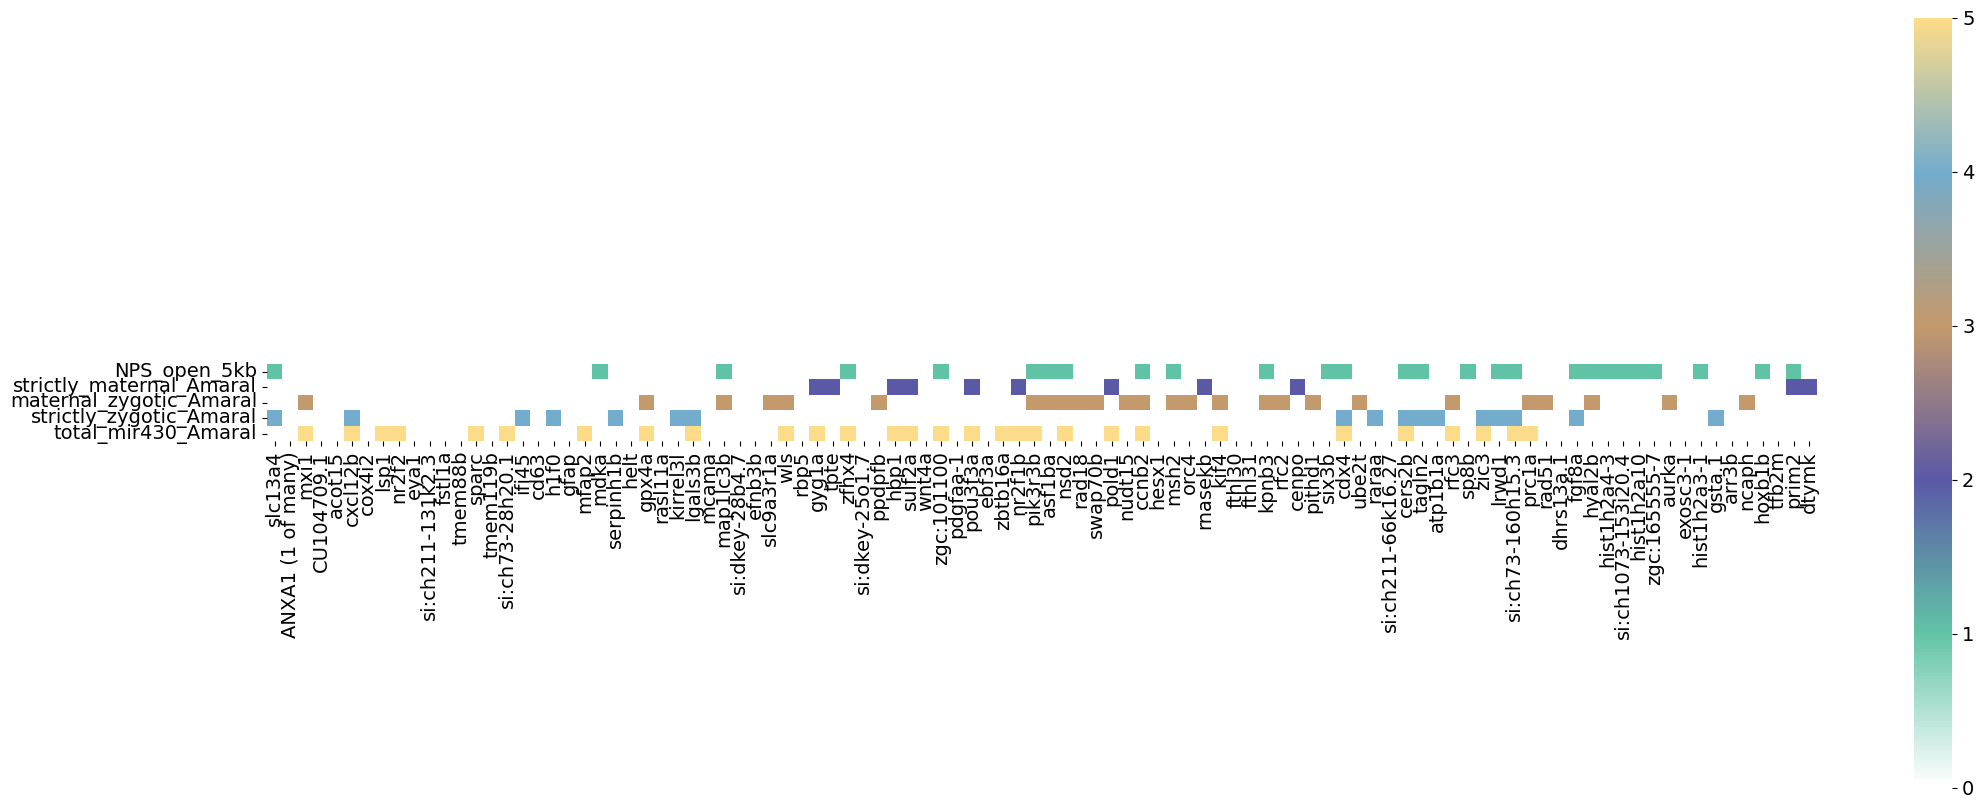

In [32]:
cols = ['#61c3a6', '#5b58a6', '#c49a6c', '#74accd', '#fddc89'][:len(MZT_lists)]
cmap0 = mpl.colors.LinearSegmentedColormap.from_list('', ["White", *cols])

df = sdata.var.loc[[i for v in DEGs.values() for i in v], MZT_lists].astype(int)
counter = 1
for i in MZT_lists:
    df[i][df[i] == 1] = counter
    counter += 1

plt.figure(figsize=(25,10))
sns.heatmap(df.T, square=True, xticklabels=True, cmap=cmap0)
# plt.savefig(f'{syncdir}/scMZnps_{clust2}_{clust1}_p01_detection_MZT_lists.pdf')

### Plot detection and MZT annotation of common marker genes

/tmp/ipykernel_855377/2398984525.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .obs.groupby('Tissue_KO_clusters')


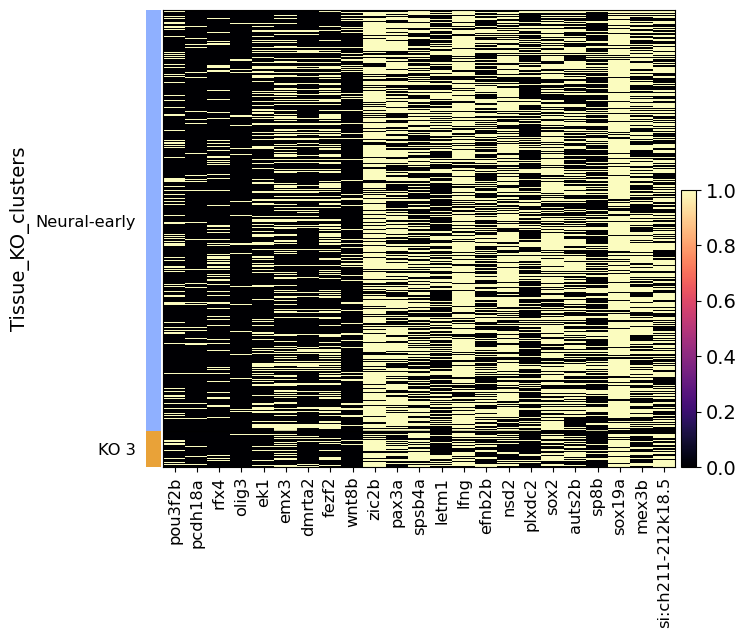

In [34]:
# Identify cells of interest (COIs)
COIs = (
    sdata[sdata.obs['Tissue_KO_clusters'].isin([clust1, clust2])]
    .obs.groupby('Tissue_KO_clusters')
    .head(200)
    .index.to_list()
    + sdata[sdata.obs['Tissue_KO_clusters'].isin([clust1, clust2])].obs.index.to_list()
)

# Generate the heatmap
sc.pl.heatmap(
    sdata[sdata.obs.index.isin(COIs)],  # Subset AnnData to cells of interest
    diff_markers['common'],  # Filtered list of DEGs
    groupby='Tissue_KO_clusters',  # Group by the specified cluster
    use_raw=False,  # Use processed data, not raw
    dendrogram=False,  # Disable dendrogram
    vmax=1,  # Maximum color value
    layer='X_preNorm',  # Use the specified layer
    cmap='magma',  # Colormap
    standard_scale=None,  # No scaling applied
    swap_axes=False,  # Do not swap axes
    show_gene_labels=True,  # Display gene labels
    save=f'scMZnps_{clust2}_{clust1}_common_marker_detection.pdf'  # Save the plot
)


/tmp/ipykernel_855377/4078880678.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[i][df[i] == 1] = counter
/tmp/ipykernel_855377/4078880678.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setti

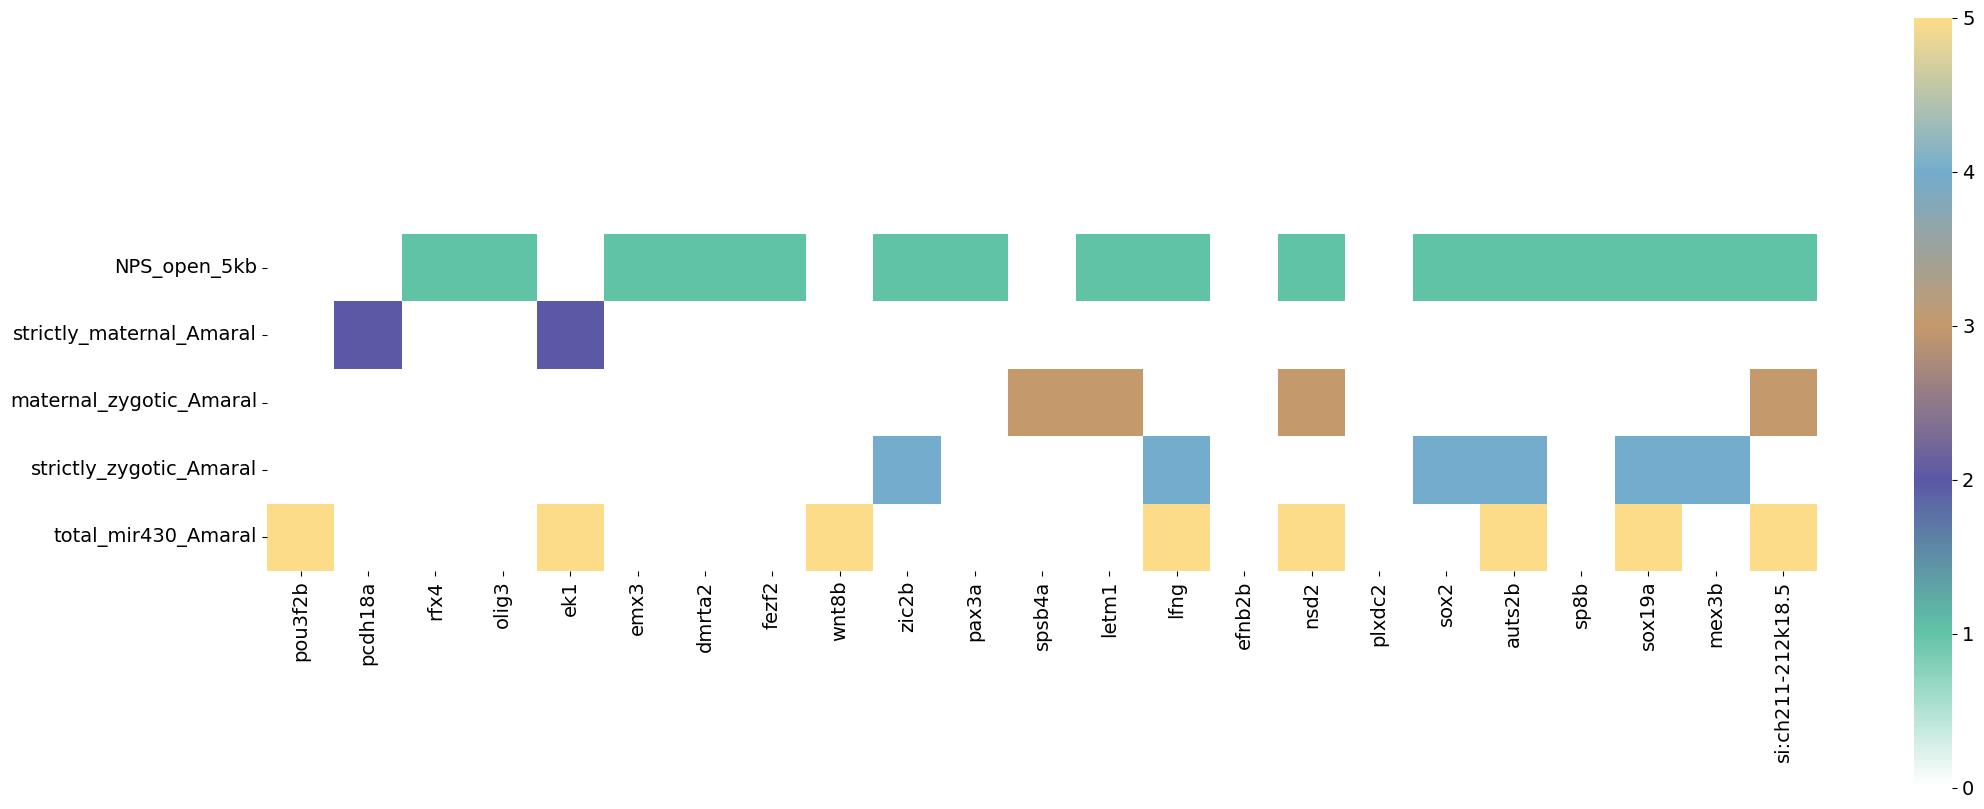

In [35]:
cols = ['#61c3a6', '#5b58a6', '#c49a6c', '#74accd', '#fddc89'][:len(MZT_lists)]
cmap0 = mpl.colors.LinearSegmentedColormap.from_list('', ["White", *cols])

df = sdata.var.loc[diff_markers['common'], MZT_lists].astype(int)
counter = 1
for i in MZT_lists:
    df[i][df[i] == 1] = counter
    counter += 1

plt.figure(figsize=(25,10))
sns.heatmap(df.T, square=True, xticklabels=True, cmap=cmap0)
plt.savefig(f'{syncdir}/scMZnps_{clust2}_{clust1}_common_marker_detection_MZT_lists.pdf')

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


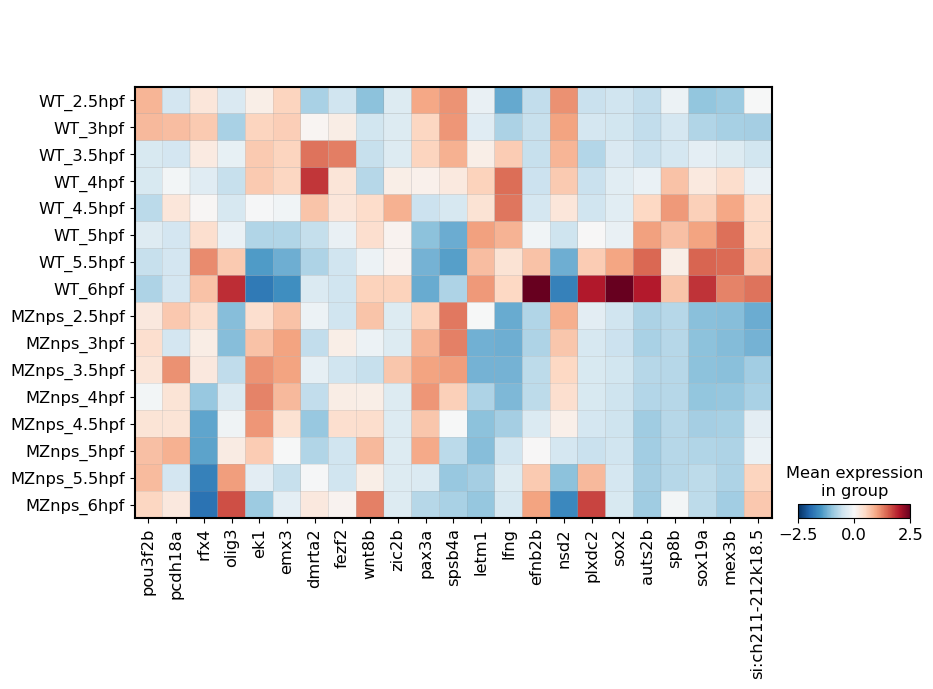

In [36]:
# Visualise marker expression temporally
sdata_bulk.obs['Sample_type'] = sdata_bulk.obs['Sample_type'].cat.reorder_categories(['WT_2.5hpf', 'WT_3hpf', 'WT_3.5hpf', 'WT_4hpf', 'WT_4.5hpf', 'WT_5hpf', 'WT_5.5hpf', 'WT_6hpf','MZnps_2.5hpf', 'MZnps_3hpf', 'MZnps_3.5hpf', 'MZnps_4hpf', 'MZnps_4.5hpf', 'MZnps_5hpf', 'MZnps_5.5hpf',  'MZnps_6hpf'])

# Generate a matrix plot for specified DEGs across 'Sample_type'
gene_list = diff_markers['common']

sc.pl.matrixplot(
    sdata_bulk, 
    gene_list,  # List of genes to plot
    groupby='Sample_type',  # Grouping by 'Sample_type'
    standard_scale=None,  # No scaling applied
    cmap='RdBu_r',  # Diverging colormap
    layer='X_scaled',  # Use scaled data
    vmin=-2.5,  # Minimum color value
    vmax=2.5,  # Maximum color value
    swap_axes=False,  # Do not swap axes
    # save=f'scMZnps_{clust2}_{clust1}_p01_bulk_timecourse.pdf'  # Save file
)


In [55]:
raise SystemExit("Relaxing...")

SystemExit: Relaxing...

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
